In [11]:
import numpy as np

from system import (
    states,
    actions, 
    wind_col,
    num_states,
    num_actions,
    init_mdp,
    init_reward,
    to_idx,
    get_valid_actions,
    gen_random_sa,
    rows,
    cols
)
from model import Model
from policy import Policy, PolicyInit
from agent import Agent

In [20]:
mdp = init_mdp(num_states, num_actions, wind_col)
reward = init_reward(num_states, t_reward=100)
model = Model(mdp, reward)

policy = Policy(num_states, num_actions, PolicyInit.RANDOM)

agent = Agent(model, policy)

In [24]:
Q_val = np.random.uniform(-10, 0, (num_states, num_actions))
# Q_val = np.zeros((num_states, num_actions))
returns = [[[] for a in range(num_actions)] for s in range(num_states)]
valf_list = [(np.max(Q_val, axis=1))]

i = 0
T = 1000
gamma = 0.9

while i < 1000:
    start_state, start_action = gen_random_sa()
    estates, eactions, erewards = agent.gen_episode(start_state, start_action, T)
    T = len(erewards)

    fo = {}
    for j in range(T):
        s = tuple(estates[j])
        a = eactions[j]
        r = erewards[j]
        if (s, a) not in fo:
            fo[(s, a)] = j
    g = 0
    
    for j in range(T):
        s = tuple(estates[T - j - 1])
        a = eactions[T - j - 1]
        r = erewards[T - j - 1]
        g = gamma * g + r
        if T - j - 1 == fo[(s, a)]:
            returns[to_idx(s)][a].append(g)
            Q_val[to_idx(s), a] = np.mean(returns[to_idx(s)][a])
            # policy.set_action(np.array(s), np.argmax(Q_val[to_idx(s)]))
    
    valf_list.append(np.max(Q_val, axis=1))
    for s in states:
        valid_actions = get_valid_actions(s, idx=True)
        action = valid_actions[np.argmax(Q_val[to_idx(s)][valid_actions])]
        policy.set_action(s, action)
    agent.change_policy(policy)
    i += 1
    print(f"Iteration {i}")

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteratio

In [25]:
valf = valf_list[-1]

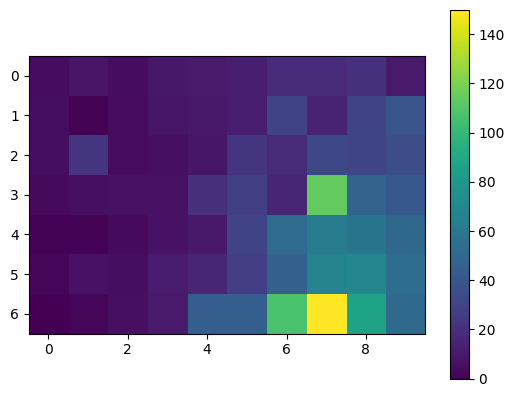

In [26]:
import matplotlib.pyplot as plt
valf_toplot = valf.reshape(rows, cols)
plt.gca().invert_yaxis()
heatmap = plt.imshow(valf_toplot)
plt.colorbar(heatmap)
plt.show()

In [37]:
# Run agent
score = 0
steps = 0
s = np.array([3,0])

path = [s]

while(steps < 1000):
    a = policy.get_action(s)

    s_ = model.gen_next(s, a)
    path.append(s_)

    r = model.get_reward(s, s_)
    score += r
    print(f"State: {s}, Action: {actions[a]}, Next State: {s_}, Reward: {r}")

    if(r!= -1):
        print(f"Game Over - Score: {score}")
        break
    
    s = s_
    steps += 1

State: [3 0], Action: [0 1], Next State: [3 1], Reward: -1
State: [3 1], Action: [0 1], Next State: [3 2], Reward: -1
State: [3 2], Action: [-1  1], Next State: [2 3], Reward: -1
State: [2 3], Action: [0 1], Next State: [2 4], Reward: -1
State: [2 4], Action: [0 1], Next State: [0 5], Reward: -1
State: [0 5], Action: [0 1], Next State: [0 6], Reward: -1
State: [0 6], Action: [0 1], Next State: [0 7], Reward: -1
State: [0 7], Action: [1 1], Next State: [0 8], Reward: -1
State: [0 8], Action: [1 0], Next State: [0 8], Reward: -1
State: [0 8], Action: [1 0], Next State: [0 8], Reward: -1
State: [0 8], Action: [1 0], Next State: [1 8], Reward: -1
State: [1 8], Action: [1 1], Next State: [2 9], Reward: -1
State: [2 9], Action: [1 0], Next State: [3 9], Reward: -1
State: [3 9], Action: [ 1 -1], Next State: [4 8], Reward: -1
State: [4 8], Action: [ 1 -1], Next State: [4 7], Reward: -1
State: [4 7], Action: [1 0], Next State: [3 7], Reward: 100
Game Over - Score: 85


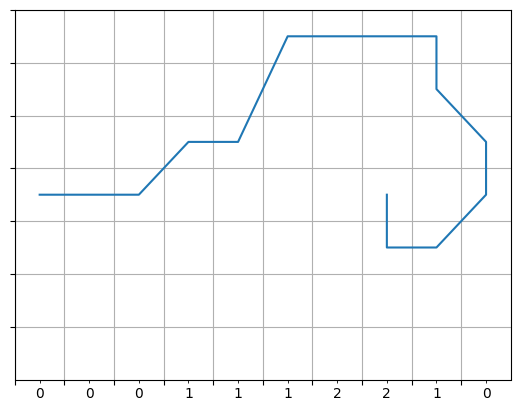

In [38]:
path_plt = np.array(path) + 0.5
y, x = path_plt.T

ax = plt.gca()
ax.grid()

ax.set_xlim(0, cols)
ax.set_xticks(np.arange(0, cols, 1), minor=False)
ax.set_xticklabels([])
ax.set_xticks(np.arange(0.5, cols, 1), minor=True)
ax.set_xticklabels([str(x) for x in wind_col], minor=True)

ax.set_ylim(rows, 0)
ax.set_yticks(np.arange(0, rows, 1), minor=False)
ax.set_yticklabels([])

ax.plot(x, y)
plt.show()